# Capstone #1

Rob Lisyb
Data Science 420

In [35]:
from os import path
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# some sklearn helpers!
from sklearn.feature_selection import VarianceThreshold

# We're going to use PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


# SECOM data set is from here:
# https://archive.ics.uci.edu/ml/datasets/SECOM

dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
secom = 'secom.data'
secom_labels = 'secom_labels.data'

def download_if_not_exists(URL: str, filename: str):
    """
    Helper function to download the file at the URL if it doesn't already exist
    :param URL: A string with the URL location
    :param filename: The file name on disk
    """
    
    if path.exists(f"{filename}"):
        return
    else:
        req = requests.get(URL)
        url_content = req.content
        csv_file = open(f"{filename}", 'wb')
        csv_file.write(url_content)
        csv_file.close()
    return

download_if_not_exists(dataset, secom)
download_if_not_exists(labels, secom_labels)

secom = pd.read_csv(secom, header=None, sep=' ')
secom = secom.add_prefix('sensor_')
secom.head()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_580,sensor_581,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [2]:
# Let's clean up the data types for this data set, rename these columns... that kinda thing
label_df = pd.read_csv(secom_labels, header=None, sep=' ')

label_df.columns = ['class', 'datetime']
# Ok, time for some column clean up...
label_df['datetime'] = pd.to_datetime(label_df.iloc[:, 1], errors='coerce')
label_df['class'] = label_df.iloc[:, 0]
label_df.head()

,class,datetime
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


<AxesSubplot:xlabel='datetime', ylabel='class'>

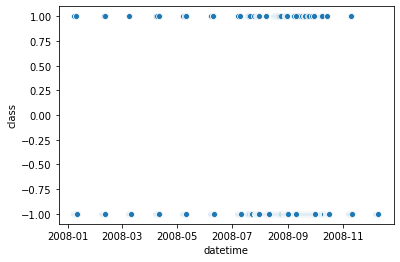

In [3]:
# Just looking at the distribtion of some data
sns.scatterplot(x='datetime', y='class', data=label_df)
# Looks like noise... probably no hard pattern here about timing for errors

In [4]:
# Let's see if these 2 data frames can join up...
print(secom.shape)
print(label_df.shape)

# yep... 1567 rows.

(1567, 590)
(1567, 2)


In [5]:
df = pd.concat(objs = [secom, label_df], axis=1)
df.head()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589,class,datetime
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


In [6]:
df.dtypes

sensor_0             float64
sensor_1             float64
sensor_2             float64
sensor_3             float64
sensor_4             float64
                   ...      
sensor_587           float64
sensor_588           float64
sensor_589           float64
class                  int64
datetime      datetime64[ns]
Length: 592, dtype: object

<AxesSubplot:>

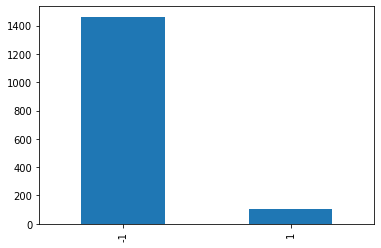

In [7]:
# Let's see the distribution of the outcome class
df['class'].value_counts().plot(kind='bar')

### Looks like the class is SUPER imbalanced

At some point we're probably going to be asked to assess the impact of each of the sensors on the outcome variable (class).

Let's see which columns have lots of NaN values...

In [8]:
df.loc[:, df.isna().any()]
# 538 columns with NaN values... 

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_580,sensor_581,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


In [9]:
df.describe()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_581,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589,class
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


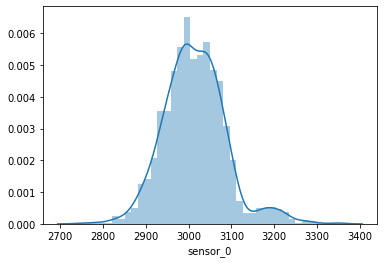

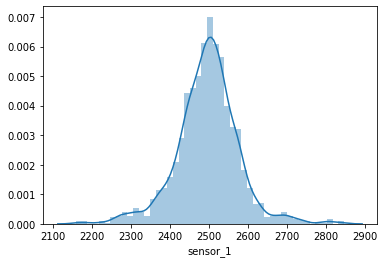

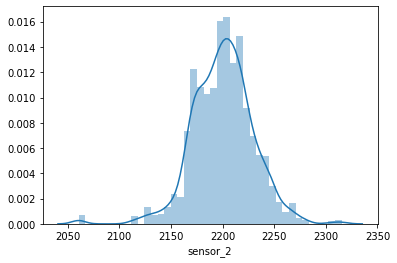

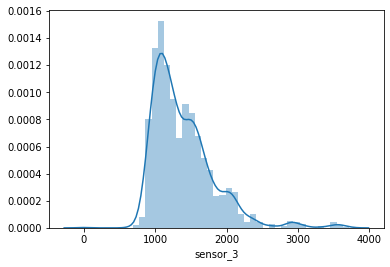

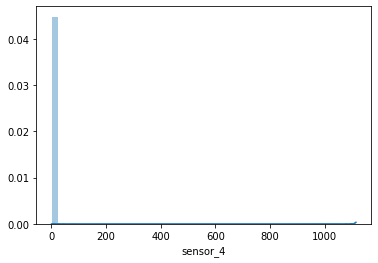

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


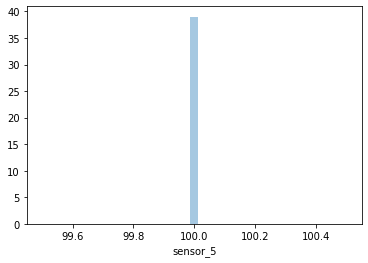

In [10]:
plot_cols = ['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
for c in plot_cols:
    sns.distplot(df[c])
    plt.show()

# Distributions

There look to be columns which have very little variance... those contain no information, so we can probably remove those (since they won't be informative for any model)

In [11]:
# Let's drop columns with very little variance, 
# as they have little information in them!

# This kinda counts as a feature selection technique... sort of...
selector = VarianceThreshold(threshold=.0001)
secom2 = pd.DataFrame(selector.fit_transform(secom))

secom2 = secom2.add_prefix('sensor_')
secom2.shape

# Looks like we dropped a few columns!

(1567, 419)

# Interpolation

Some of our observations have missing data... we'll interpolate new values for these missing observations. We'll use the median to fill these in.

In [26]:
for c in secom2:
    secom2[c].fillna((secom2[c].median()), inplace=True)
    
secom2.isnull().sum().sum()

0

# PCA

We're going to reduce further the number of columns we're looking at here using Principal Component Analysis (aka PCA).

#### Why?
PCA will let us simplify the number of attributes without losing too much of the explanation of the variance. To do this we have to scale the variables then create a PCA using sklearn.

In [27]:
# PCA requires us to scale and standardize our features.
features = secom2.columns
x = secom2.loc[:, features].values
x = StandardScaler().fit_transform(x)
secom_std = pd.DataFrame(x)
secom_std.head()

# gotta rejoin the data frames now that we have fewer columns...
df = pd.concat(objs = [secom_std, label_df], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,411,412,413,414,415,416,417,418,class,datetime
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,-0.564354,0.509848,1.128455,-1.515617,0.763117,...,-0.229797,-0.135520,-0.064866,-0.179550,-0.204833,-0.197057,-0.077554,-0.295753,-1,2008-07-19 11:55:00
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.197639,0.457021,0.022620,-0.133006,0.181528,...,-0.263493,-0.460054,-1.527375,2.233265,0.406734,0.385113,-0.960123,1.156846,-1,2008-07-19 12:32:00
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,-0.906768,-0.260885,0.327222,-0.229467,0.633530,...,-0.205046,-0.590505,5.081000,0.008115,0.022320,0.029888,2.991195,-0.178955,1,2008-07-19 13:17:00
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.502662,0.343240,-0.765369,-0.116929,0.581382,...,-0.224950,-0.645708,-0.091949,-0.151957,-0.292200,-0.283360,-0.101845,-0.275049,-1,2008-07-19 14:43:00
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,-0.115954,0.545066,-0.149545,-0.599235,0.610329,...,-0.230791,-0.454486,-0.064866,-0.179550,26.867221,26.913337,-0.101845,-0.275049,-1,2008-07-19 15:22:00


In [30]:
# Create the PCA which explains 95% of the variance.
pca = PCA(n_components = 0.95)
pca.fit(x)
reduced = pd.DataFrame(pca.transform(x))
reduced.shape

(1567, 155)

In [31]:
df = pd.concat(objs = [reduced, label_df], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,class,datetime
0,-1.725017,2.070644,3.793966,-1.764137,-1.842904,1.001274,-0.777821,0.964500,0.460575,0.697973,...,-0.260994,-0.279400,1.116986,0.228593,0.281360,-0.060353,1.519399,0.771868,-1,2008-07-19 11:55:00
1,-2.233080,0.195284,2.970141,-1.725695,-2.127683,1.124351,-1.291922,1.656877,-1.476874,1.819507,...,0.739818,-0.599039,0.469250,-1.222626,0.362525,-0.453749,-0.119534,-0.222659,-1,2008-07-19 12:32:00
2,0.380529,0.440720,1.458695,-0.757470,0.956848,0.141994,-1.621071,0.279613,-0.662539,1.553010,...,-0.247273,-0.893866,1.725240,0.399593,0.314374,-0.050679,-0.536643,-0.116711,1,2008-07-19 13:17:00
3,1.134229,4.571565,5.535867,-3.546691,1.186742,4.117905,-6.021492,-4.577591,11.799256,7.754128,...,-1.027651,0.948729,-0.987189,-1.185375,0.644864,-0.127283,0.101113,-0.656838,-1,2008-07-19 14:43:00
4,0.610439,1.745529,2.833360,0.174149,2.575236,1.771740,-4.176679,0.202220,3.515285,-1.304979,...,-0.444838,0.347133,0.120014,0.782092,-0.197101,0.605807,-0.760315,0.398556,-1,2008-07-19 15:22:00


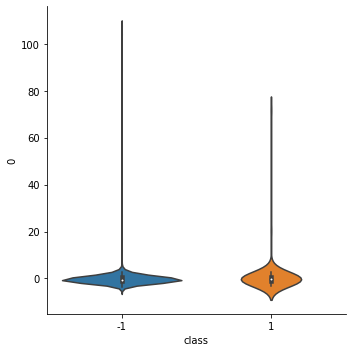

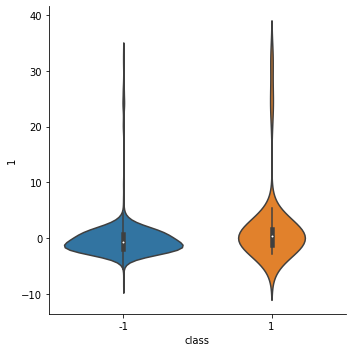

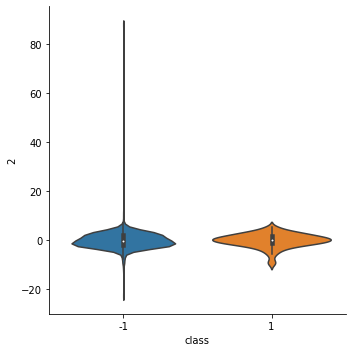

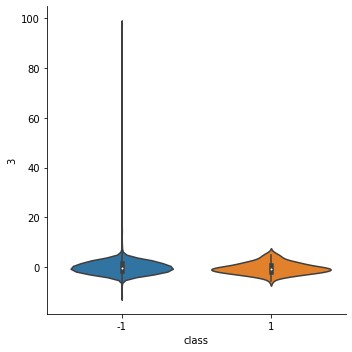

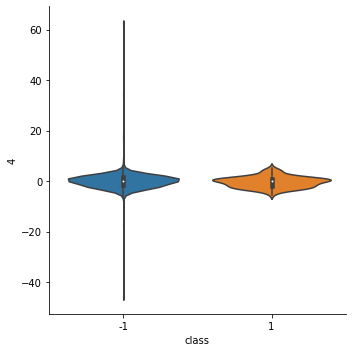

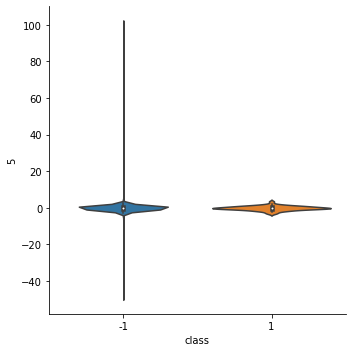

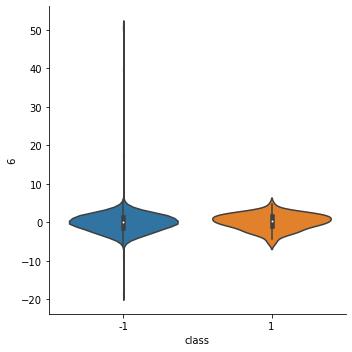

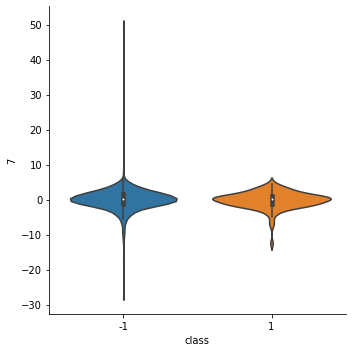

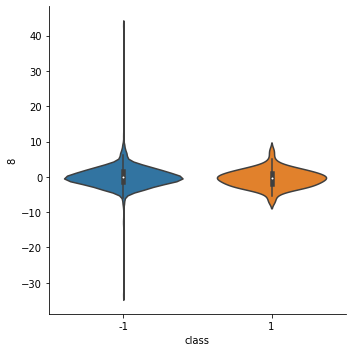

In [38]:
# Lets see if we can visualize any seperation between the classes.
for c in range(0,9):
    sns.catplot(x='class', y=c, kind='violin', data=df)
    plt.show()

# Summary

We've processed and loaded the data, cleaned it, replaced missing values with the median, dropped columns with low variance (aka little information), and then reduced the number of columns through PCA.

Note - I have chosen to NOT "handle" the class imbalance problem yet, because frankly it is not a problem yet. Class imbalances are only problematic in the presence of specific algorithims. Some algos deal well with imbalanced classes while some do not. I'm not sure yet which algos I'll be investigating, so I will not be using something like SMOTE to upsample/downsample our class imbalance.

A small sample plot of the resulting columns, split by the "class" shows that there looks to be a large amount of overlap between class "-1" and "1". This could be challenging later on, as most ML models require some level of distance in the predictors to accurately distinguish between classes.